In [5]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

n_state = 10
n_action = 5
n_samples = 100

discount = 0.5

# TODO USE ACTUAL MAPPED INSTANCES INSTEAD OF THESE RANDOMLY GENERATED VECTORS
actions = np.random.binomial(n_action-1,[1/n_action],n_samples)
instances = np.arange(n_state*n_samples).reshape(n_samples,n_state).astype(float)
transitions = np.arange(n_state*n_samples).reshape(n_samples,n_state).astype(float)
rewards = -np.ones((n_samples))

n_layer1 = 15
n_layer2 = 15
n_layer3 = 15

# TODO STANDARDIZE INPUTS AND OUTPUTS

initializer = tf.truncated_normal_initializer
ini_mean = 0
ini_std = 1
activation = tf.nn.relu

def weight_matrix(n_from,n_to):
    return tf.Variable(tf.truncated_normal(
        shape=(n_from,n_to)
        ,mean=ini_mean
        ,stddev=ini_std/(n_from+n_to)
        ,dtype=tf.float32))

def bias_matrix(n_to):
    return tf.Variable(tf.zeros(shape=(1,n_to),dtype=tf.float32))


q_input = tf.placeholder(name='q_input', shape=(None,n_state),dtype=tf.float32)

q_w1 = weight_matrix(n_state,n_layer1)
q_b1 = bias_matrix(n_layer1)
q_layer1 = activation(tf.matmul(q_input,q_w1) + q_b1)
q_w2 = weight_matrix(n_layer1,n_layer2)
q_b2 = bias_matrix(n_layer2)
q_layer2 = activation(tf.matmul(q_layer1,q_w2)+ q_b2)
q_w3 = weight_matrix(n_layer2,n_layer3)
q_b3 = bias_matrix(n_layer3)
q_layer3 = activation(tf.matmul(q_layer2,q_w3)+ q_b3)
q_wout = weight_matrix(n_layer3,n_action)

q_bpred = bias_matrix(n_action) 
q_pred = tf.matmul(q_layer3,q_wout) + q_bpred

q_output = tf.placeholder(name='q_output',shape=(None,n_action),dtype=tf.float32)
loss = tf.nn.l2_loss(q_output - q_pred)

opt = tf.train.MomentumOptimizer(
    learning_rate=0.000001,
    momentum=0.7)

opt_op = opt.minimize(loss, var_list = [q_w1,q_w2,q_w3,q_wout])

builder = tf.saved_model.builder.SavedModelBuilder("./tmp/model.ckpt")

loss: 14.084392547607422: 100%|██████████| 500/500 [00:01<00:00, 466.06it/s]

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: b'./tmp/model.ckpt/saved_model.pb'
done - model saved at b'./tmp/model.ckpt/saved_model.pb'


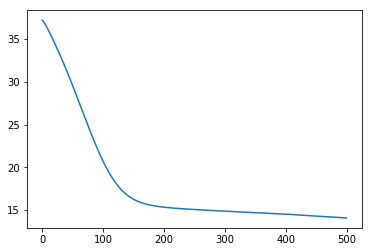

In [6]:
n_epochs = 500

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
pbar = tqdm(range(n_epochs))
_losses = []
for _ in pbar:

    bellman_trans_q = np.max(sess.run(q_pred, feed_dict={q_input:transitions}),axis=1)

    ground_truth = sess.run(q_pred, feed_dict={q_input:instances})
    ground_truth[list(range(n_samples)),actions] = rewards + discount*bellman_trans_q

    sess.run(opt_op,feed_dict={q_input:instances, q_output:ground_truth})
    _loss = sess.run(loss,feed_dict={q_input:instances, q_output:ground_truth})
    _losses.append(_loss)
    pbar.set_description('loss: {}'.format(_loss))
    
    ### TODO : Save model w/trained variables for use in target task
    
builder.add_meta_graph_and_variables(sess,
                                     ['q_learning']
                                        
                                       )

save_path = builder.save()

print('done - model saved at', save_path)

sess.close()
    
plt.plot(list(range(n_epochs)),_losses)
plt.show()

In [7]:
rewards + discount*bellman_trans_q

array([-0.99922163, -0.99756866, -0.99592048, -0.99427644, -0.99263271,
       -0.99098897, -0.98934524, -0.9877015 , -0.98605777, -0.98441403,
       -0.98277029, -0.98112656, -0.97948282, -0.97783909, -0.97619536,
       -0.97455162, -0.97290788, -0.97126415, -0.96962042, -0.96797668,
       -0.96633294, -0.96468921, -0.96304547, -0.96140174, -0.959758  ,
       -0.95811427, -0.95647053, -0.9548268 , -0.95318307, -0.95153933,
       -0.94989558, -0.94825185, -0.94660812, -0.94496438, -0.94332065,
       -0.94167691, -0.94003318, -0.93838945, -0.93674571, -0.93510199,
       -0.93345824, -0.9318145 , -0.93017077, -0.92852703, -0.9268833 ,
       -0.92523956, -0.92359584, -0.92195209, -0.92030836, -0.91866461,
       -0.91702089, -0.91537716, -0.91373342, -0.91208969, -0.91044594,
       -0.9088022 , -0.90715848, -0.90551474, -0.903871  , -0.9022273 ,
       -0.90058354, -0.8989398 , -0.89729609, -0.89565233, -0.89400859,
       -0.89236487, -0.89072112, -0.88907739, -0.88743366, -0.88

In [8]:
bellman_trans_q

array([ 0.00155675,  0.00486267,  0.00815904,  0.01144711,  0.01473459,
        0.01802206,  0.02130952,  0.024597  ,  0.02788446,  0.03117194,
        0.03445941,  0.03774688,  0.04103435,  0.04432182,  0.04760929,
        0.05089676,  0.05418424,  0.0574717 ,  0.06075917,  0.06404664,
        0.06733412,  0.07062159,  0.07390906,  0.07719652,  0.080484  ,
        0.08377147,  0.08705894,  0.0903464 ,  0.09363387,  0.09692135,
        0.10020883,  0.1034963 ,  0.10678376,  0.11007124,  0.11335869,
        0.11664617,  0.11993365,  0.12322111,  0.12650858,  0.12979603,
        0.13308352,  0.136371  ,  0.13965845,  0.14294593,  0.14623341,
        0.14952087,  0.15280832,  0.15609582,  0.15938328,  0.16267078,
        0.16595821,  0.16924568,  0.17253317,  0.17582062,  0.17910813,
        0.18239559,  0.18568304,  0.18897052,  0.192258  ,  0.19554541,
        0.19883293,  0.20212041,  0.20540783,  0.20869534,  0.21198282,
        0.21527027,  0.21855776,  0.22184522,  0.22513269,  0.22